In [24]:
#Natural Gas Forecaster
#Architecture: hybrid lstm + arima
#Shaman Shetty

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL

# LSTM stack
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)#good practice :|


# 1. LOAD THE MONTHLY DATA

# =============================
# 1. UPLOAD & READ THE CSV FILE
# =============================

from google.colab import files
import pandas as pd

# Upload the CSV from your laptop
uploaded = files.upload()

# Get the filename dynamically
filename = list(uploaded.keys())[0]

# Read the CSV
df = pd.read_csv(filename)

# Clean column names if needed
df.columns = df.columns.str.strip()

# Ensure the correct column names
# (Change these if your CSV uses different names)
expected_date_col = "Dates"
expected_price_col = "Prices"

# Parse dates
df[expected_date_col] = pd.to_datetime(df[expected_date_col], errors="coerce")

# Convert prices (handles scientific notation like 1.01E+01)
df[expected_price_col] = pd.to_numeric(df[expected_price_col], errors="coerce")

# Remove bad rows
df = df.dropna()

# Rename for consistency with your hybrid model code
df = df.rename(columns={
    expected_date_col: "Date",
    expected_price_col: "Price"
})

# Set index and sort
df = df.set_index("Date").sort_index()

print("Cleaned dataset:")
display(df.head())

print("Date range:", df.index.min(), "→", df.index.max())





Saving Nat_Gas.csv to Nat_Gas (2).csv
Cleaned dataset:


/tmp/ipython-input-2637843995.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[expected_date_col] = pd.to_datetime(df[expected_date_col], errors="coerce")


,Price
Date,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


Date range: 2020-10-31 00:00:00 → 2024-09-30 00:00:00


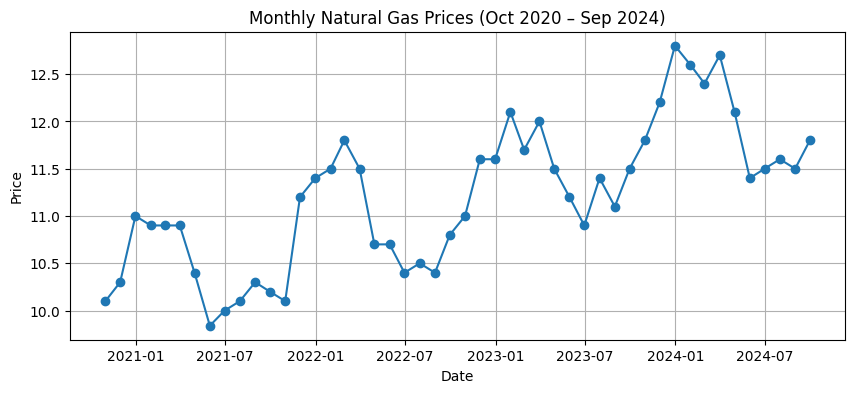

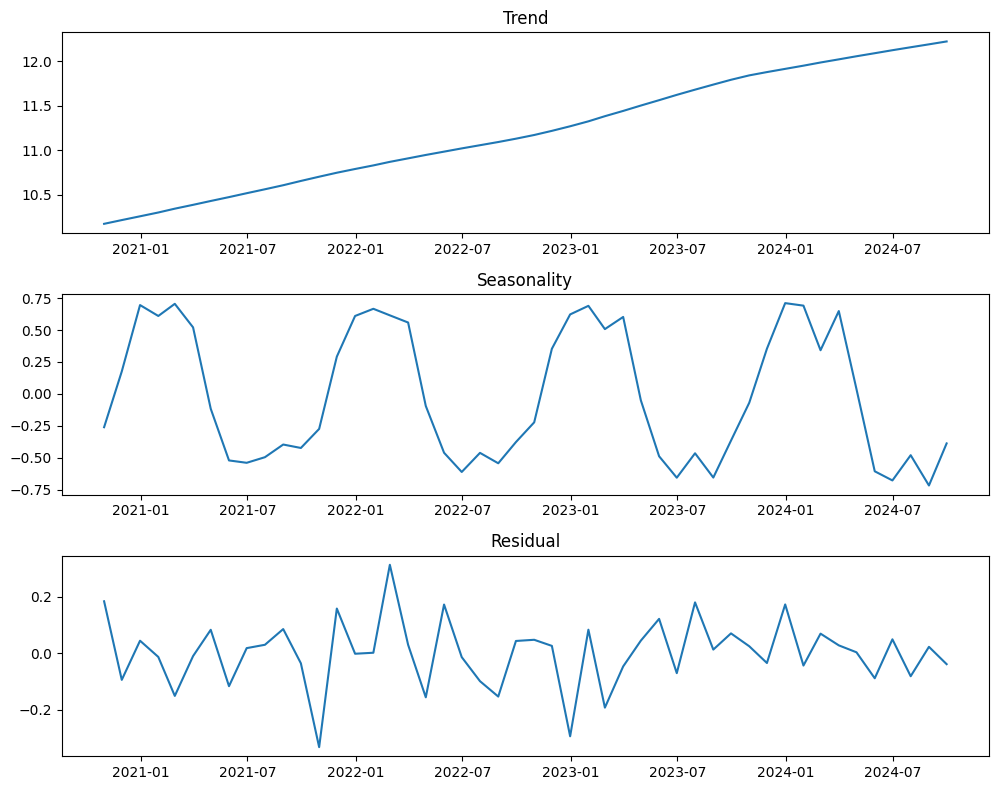

In [25]:

# 2. BASIC VISUALIZATION

plt.figure(figsize=(10, 4))
plt.plot(df.index, df["Price"], marker='o')
plt.title("Monthly Natural Gas Prices (Oct 2020 – Sep 2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

stl = STL(df["Price"], period=12)
res = stl.fit()

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(res.trend)
plt.title("Trend")

plt.subplot(3, 1, 2)
plt.plot(res.seasonal)
plt.title("Seasonality")

plt.subplot(3, 1, 3)
plt.plot(res.resid)
plt.title("Residual")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


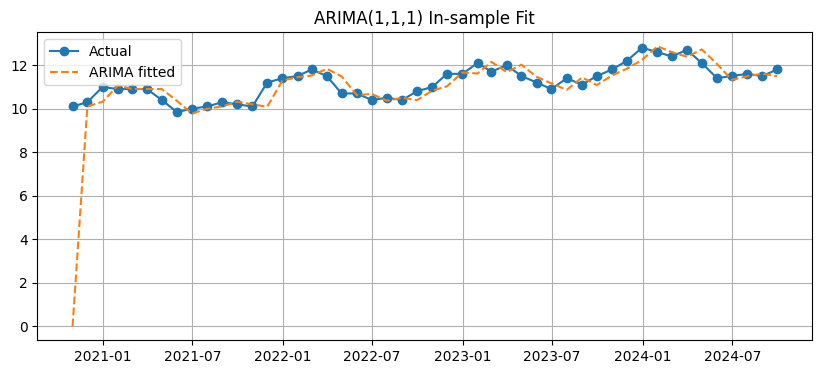

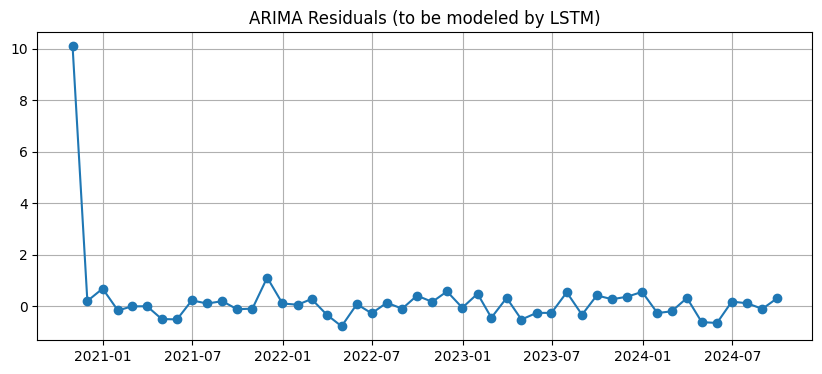

In [26]:

# 3. BASELINE ARIMA MODEL (LINEAR PART)

arima_model = ARIMA(df["Price"], order=(1, 1, 1))
arima_fit = arima_model.fit()

arima_fitted = arima_fit.predict(start=df.index[0], end=df.index[-1], typ="levels")

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Price"], label="Actual", marker='o')
plt.plot(df.index, arima_fitted, label="ARIMA fitted", linestyle='--')
plt.title("ARIMA(1,1,1) In-sample Fit")
plt.legend()
plt.grid(True)
plt.show()

residuals = df["Price"] - arima_fitted
residuals = residuals.dropna()

plt.figure(figsize=(10,4))
plt.plot(residuals.index, residuals, marker='o')
plt.title("ARIMA Residuals (to be modeled by LSTM)")
plt.grid(True)
plt.show()


In [27]:
# 4. PREP DATA FOR LSTM ON RESIDUALS

scaler = MinMaxScaler(feature_range=(-1, 1))
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, look_back=6):
    """
    Turn residual time series into supervised LSTM sequences.
    data: 1D array (scaled residuals)
    look_back: number of previous months to use as features
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

look_back = 6
X, y = create_sequences(residuals_scaled, look_back=look_back)

print("LSTM input shape:", X.shape, "LSTM target shape:", y.shape)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


LSTM input shape: (42, 6, 1) LSTM target shape: (42, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


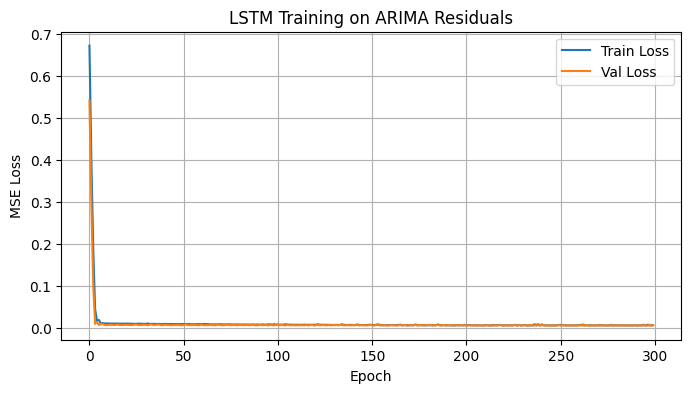

In [28]:

# 5. BUILD & TRAIN THE LSTM MODEL

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=4,
    verbose=0,
    validation_data=(X_test, y_test)
)

# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("LSTM Training on ARIMA Residuals")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()



In [29]:
# ===============================================
# 6. HYBRID FORECAST: ARIMA + LSTM RESIDUALS
# ===============================================

n_forecast_months = 12

last_date = df.index[-1]
future_index = pd.date_range(
    last_date + pd.offsets.MonthEnd(1),
    periods=n_forecast_months,
    freq="M"
)

arima_forecast = arima_fit.forecast(steps=n_forecast_months)
arima_forecast = pd.Series(arima_forecast.values, index=future_index)

# 6.2 LSTM residual forecast for same horizon

last_residuals_scaled = residuals_scaled[-look_back:].reshape(1, look_back, 1)

res_lstm_forecasts_scaled = []

for _ in range(n_forecast_months):
    next_scaled = model.predict(last_residuals_scaled, verbose=0)
    res_lstm_forecasts_scaled.append(next_scaled[0,0])

    last_residuals_scaled = np.append(
        last_residuals_scaled[:,1:,:],
        next_scaled.reshape(1,1,1),
        axis=1
    )

res_lstm_forecasts = scaler.inverse_transform(
    np.array(res_lstm_forecasts_scaled).reshape(-1,1)
).flatten()

res_lstm_forecast_series = pd.Series(res_lstm_forecasts, index=future_index)

# 6.3 Hybrid forecast = ARIMA forecast + LSTM residual forecast
hybrid_forecast = arima_forecast + res_lstm_forecast_series


/tmp/ipython-input-2484837274.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


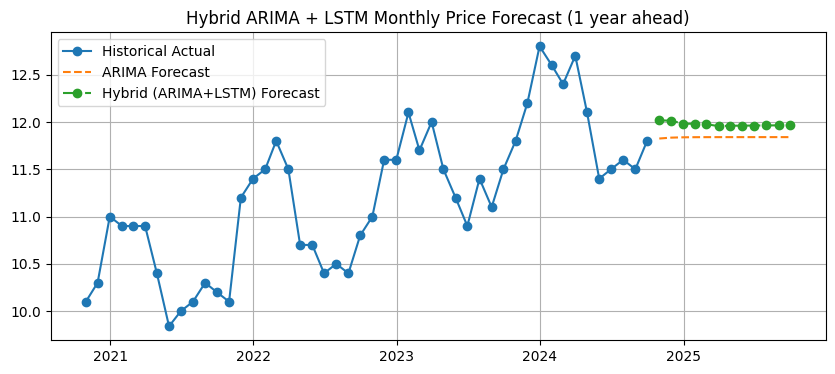

In [30]:
# 7. COMBINE HISTORICAL + FORECAST DATA
full_monthly_series = pd.concat([
    df["Price"],
    hybrid_forecast
])

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Price"], label="Historical Actual", marker='o')
plt.plot(arima_forecast.index, arima_forecast, label="ARIMA Forecast", linestyle='--')
plt.plot(hybrid_forecast.index, hybrid_forecast, label="Hybrid (ARIMA+LSTM) Forecast", linestyle='-.', marker='o')
plt.title("Hybrid ARIMA + LSTM Monthly Price Forecast (1 year ahead)")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# 8. DAILY INTERPOLATION + QUERY FUNCTION

daily_series = full_monthly_series.resample("D").interpolate()

def estimate_price(input_date_str):
    """
    Return estimated natural gas price for any date
    within [first historical date, last forecast date].
    """
    input_date = pd.to_datetime(input_date_str)
    if input_date < daily_series.index.min() or input_date > daily_series.index.max():
        return f"Date {input_date.date()} is outside the modeled range ({daily_series.index.min().date()} to {daily_series.index.max().date()})."
    return float(daily_series.loc[input_date])

# Estimate price of exactly one year after the last date on the dataset
print("Example price on 2025-09-30:", estimate_price("2025-09-30"))


Example price on 2025-09-30: 11.96553616142917
